In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from matplotlib import cm
from joypy import joyplot

from data_utils import correct_col_type,gen_date_col,transform_category_to_counts,gen_summary
###from vis_utils import vis_day_counts_ridge_plot,save_fig,vis_personal_aligned_multiview_day_plot
from data_loader import TIHM

In [14]:
DPATH = '/content/'
tihm = TIHM(root=DPATH)

In [15]:
tihm.activity_raw.shape

(1030559, 3)

In [16]:
activity = tihm.activity # aggregated activity data
activity.shape

(2722, 10)

In [17]:
activity.describe()


location_name,date,Back Door,Bathroom,Bedroom,Fridge Door,Front Door,Hallway,Kitchen,Lounge
count,2722,2135.000000,2496.000000,2526.000000,2472.000000,2453.000000,2523.000000,2556.000000,2281.000000
mean,2019-05-29 03:56:28.390888960,22.597658,32.863381,51.913302,44.014159,23.761517,76.886247,88.932707,79.249014
min,2019-04-01 00:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2019-05-14 00:00:00,7.000000,16.000000,30.000000,23.000000,10.000000,48.500000,59.000000,46.000000
50%,2019-05-31 00:00:00,14.000000,30.000000,44.000000,40.000000,18.000000,73.000000,86.000000,74.000000
75%,2019-06-15 00:00:00,28.000000,46.000000,63.000000,60.000000,30.000000,102.000000,114.000000,108.000000
max,2019-06-30 00:00:00,314.000000,250.000000,264.000000,173.000000,244.000000,264.000000,255.000000,259.000000
std,NaN,25.593749,22.500095,35.156386,26.635970,22.906572,40.083370,41.767526,45.354658


In [18]:
physiology_raw = tihm.physiology_raw
physiology = tihm.physiology

In [19]:
sleep.describe()

NameError: name 'sleep' is not defined

In [20]:
tihm.demographic_raw.head()
tihm.demographic.head()

,patient_id,age,sex
49,0697d,"(80, 90]",Male
35,099bc,"(80, 90]",Female
16,0cda9,"(70, 80]",Female
7,0d5ef,"(70, 80]",Male
20,0efe8,"(70, 80]",Female


In [21]:
tihm.demographic_types

['age', 'sex']

In [22]:
files = os.listdir(DPATH)
data_dict = {}
summaries = {}
for f in files:
    if 'csv' not in f:
        continue
    print(f)
    fpth = os.path.join(DPATH,f)
    df = pd.read_csv(fpth)

    for col in df.columns:
        df[col] = correct_col_type(df,col)

    if 'date' in df.columns:
        df = df.rename(columns={'date':'timestamp'})

    fname = f.split('.')[0]
    data_dict[fname] = df

    summaries[fname] = gen_summary(df)

Sleep.csv
Labels.csv
Physiology.csv
Activity.csv
Demographics.csv


In [23]:
## Set colour palette
ibm_colorblind = ['#648FFF', '#FE6100', '#DC267F', '#785EF0', '#FFB000','#48A9A6']
sns.set_palette(ibm_colorblind)


In [24]:
file = pd.read_csv(r'/content/Labels.csv')
lbl_df = pd.DataFrame(file)
lbl_df['date'] = pd.to_datetime(lbl_df['date'])
type_counts = lbl_df['type'].value_counts()
print(type_counts)

type
Blood pressure      305
Agitation           135
Pulse                95
Body water           68
Weight                4
Body temperature      1
Name: count, dtype: int64


In [25]:
file = pd.read_csv(r'/content/Activity.csv')
act_df1 = pd.DataFrame(file)

act_df1['date'] = pd.to_datetime(act_df1['date'])
type_counts = act_df1['location_name'].value_counts()
print(type_counts)

location_name
Kitchen        227312
Hallway        193984
Lounge         180767
Bedroom        131133
Fridge Door    108803
Bathroom        82027
Front Door      58287
Back Door       48246
Name: count, dtype: int64


In [26]:
act_df = transform_category_to_counts(act_df1,col='location_name',keys=['patient_id','date'])
act_df.head()

location_name,patient_id,date,Back Door,Bathroom,Bedroom,Fridge Door,Front Door,Hallway,Kitchen,Lounge
0,0697d,2019-06-28 13:03:29,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1,0697d,2019-06-28 13:11:44,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,0697d,2019-06-28 13:13:50,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
3,0697d,2019-06-28 13:13:53,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,0697d,2019-06-28 13:14:09,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [27]:
p_ct = act_df.groupby('date').size().to_frame('Number of Patients')
act_df.groupby('patient_id').size().mean()

18255.0

Text(0, 0.5, 'Number of Paticipants')

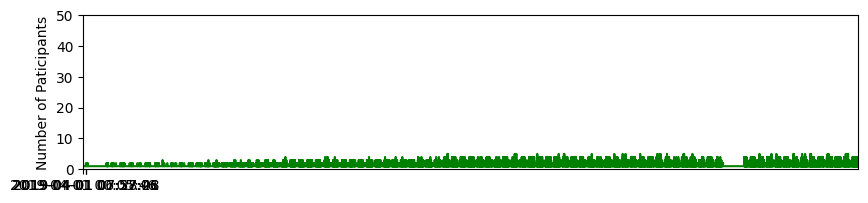

In [28]:
plt.figure(figsize=[10,2])
plt.plot(p_ct,color='g')
idx = [0,29,60,88]
plt.xticks(p_ct.index[idx],labels=p_ct.index[idx])

plt.xlim(p_ct.index[0],p_ct.index[-1])
plt.yticks(np.arange(0,60,10))
plt.ylabel('Number of Paticipants')


In [32]:
## Training and evaluating baselines

for k in range(K):
    split = end_date - window
    train_X = X.loc[(pd.to_datetime(X.date)-pd.to_datetime(split))<=pd.Timedelta(0,'D')]
    test_X = X.loc[((pd.to_datetime(X.date)-pd.to_datetime(split))>pd.Timedelta(0,'D'))
                   &((pd.to_datetime(X.date)-pd.to_datetime(split))<=window)]
    print('check date',np.sort(train_X.date)[-1],np.sort(test_X.date)[-1],np.sort(test_X.date)[0])
    end_date = split

    train_X = train_X.drop(keys,axis=1)
    test_X = test_X.drop(keys,axis=1)

    if test_X.label.sum()==0:
        print('No positive labels in test set!')
        continue

    test_y = test_X.label.values
    train_y = train_X.label.values


    train_X = train_X.drop('label',axis=1).values
    test_X = test_X.drop('label',axis=1).values

    tX.append(test_X)



    ros = RandomOverSampler(random_state=sd)
    train_X, train_y = ros.fit_resample(train_X, train_y)

    CLFs = [GradientBoostingClassifier(n_estimators=20,min_samples_leaf=1,random_state=sd),
           MLPClassifier(hidden_layer_sizes=(128,128),max_iter=300,activation='tanh',alpha=0.001,early_stopping=True,random_state=sd),
           LogisticRegression(max_iter=5000,random_state=sd),
           GaussianNB(),
           GaussianProcessClassifier(random_state=sd),]
    print('Test {}, positive proportion: {}'.format(k,test_y.sum()/test_y.shape[0]))
    for clf in CLFs:
        print(clf)
        scores = {}
        label_scores[clf.__class__.__name__]=label_scores.get(clf.__class__.__name__,{})


        clf.fit(train_X,train_y)
        pred_y = clf.predict(test_X)

        cmx = confusion_matrix(test_y,pred_y)
        print('confusion matrix on separate validation set',cmx)


        sensitivity = cmx[1,1]/cmx[1,:].sum()
        sc = scores.get('sensitivity',[])
        sc.append(sensitivity)
        scores['sensitivity']=sc

        specificity = cmx[0,0]/cmx[0,:].sum()
        sc = scores.get('specificity',[])
        sc.append(specificity)
        scores['specificity']=sc

        label_scores[clf.__class__.__name__][label_type] = label_scores[clf.__class__.__name__].get(label_type,{})

        label_scores[clf.__class__.__name__][label_type][k]=scores

        if isinstance(clf,GradientBoostingClassifier):
            explainer = shap.TreeExplainer(clf, model_output='probability', data=train_X)
            shap_values[clf.__class__.__name__] = shap_values.get(clf.__class__.__name__,[])
            shap_values[clf.__class__.__name__].append(explainer.shap_values(test_X))

        if isinstance(clf,LogisticRegression):
            explainer = shap.LinearExplainer(clf, model_output='probability', data=train_X,masker=train_X)
            shap_values[clf.__class__.__name__] = shap_values.get(clf.__class__.__name__,[])
            shap_values[clf.__class__.__name__].append(explainer.shap_values(test_X))

NameError: name 'end_date' is not defined